### Load the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


### Data Extraction & Cleaning

In [2]:
twitter_data = pd.read_csv('Twitter_Data.csv')
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())

    for i in punc:
        cleanedText = cleanedText.replace(i, '')

    a = [i for i in cleanedText if i.isalpha() or i == ' ']

    final_text = ' '.join(''.join(a).split())
    return final_text


***Cleaning Data***

In [4]:
twitter_data = twitter_data.dropna(how='any')


In [5]:
twitter_data.rename(columns={'clean_text':'comment'}, inplace=True)

twitter_data.category = twitter_data.category.apply(lambda x: int(x))

twitter_data.comment = twitter_data.comment.apply(cleanText)


In [6]:
twitter_data.head()

,comment,category
0,when modi promised minimum government maximum ...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp to...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [7]:
twitter_data.drop_duplicates(subset='comment', keep=False, inplace=True)


### Data Visualization

***Count The Negative, Neutral, and Positive Comments***

In [8]:
negative_count = [len(twitter_data[twitter_data.category == -1])]

neutral_count = [len(twitter_data[twitter_data.category == 0])]

positive_count = [len(twitter_data[twitter_data.category == 1])]

x = ['Twitter']
x_indexes = np.arange(len(x))
width = 0.25


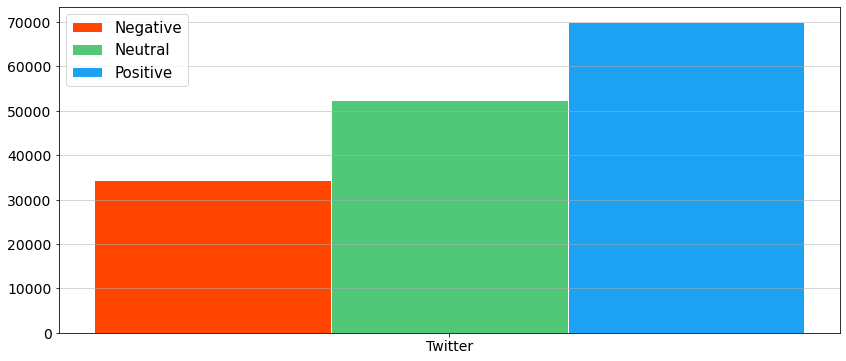

In [9]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
# plt.tight_layout()


***Count the Average Length of All the 3 Sentiments Comment***

In [10]:
negative_avg = int(sum([len(i) for i in twitter_data[twitter_data.category == -1].comment]) / len(twitter_data[twitter_data.category == -1]))
neutral_avg = int(sum([len(i) for i in twitter_data[twitter_data.category == 0].comment]) / len(twitter_data[twitter_data.category == 0]))
positive_avg = int(sum([len(i) for i in twitter_data[twitter_data.category == 1].comment]) / len(twitter_data[twitter_data.category == 1]))


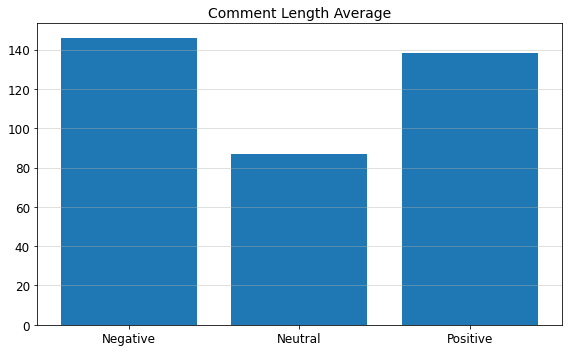

In [11]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg])

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()


***Create Word Clouds to See Which Words Appear Frequently***

In [12]:
negative_words = ''
neutral_words = ''
positive_words = ''

stopwords = set(STOPWORDS)

for comment, category in zip(twitter_data.comment, twitter_data.category):
    tokens = comment.split()

    for word in tokens:
        if word in stopwords:
          continue
        if category == -1:
            negative_words += word + ' '
        elif category == 0:
            neutral_words += word + ' '
        else:
            positive_words += word + ' '


In [19]:
for word in range(0, 7500):
  print(positive_words[word],end="")

say vote modi welcome bjp told rahul main campaigner modi think modi relax asking supporters prefix chowkidar names modi great service now confusion read now crustal clear will crass filthy nonsensical see abuses coming chowkidars answer among powerful world leader today trump putin modi may upcoming election india saga going important pair look current modi leads govt elected deal brexit combination weekly looks juicy bears imho gandhi gay modi things demonetisation gst goods services taxthe upper castes sort either view favourably say need give time castes dalits muslims modi constituency hope tuthukudi people prefer honest well behaved nationalist courageous likly minister modi cabinet vote benifit thuthukudi calm waters wheres modi wave dont play words talking modi swamy relation guru saying good chowkidar protecting good mind tweeted dark side terrorism brighter side better know one recently said people vote modi anti national put gen hooda congress supporters jawans support modi 

In [20]:
negative_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_words)

neutral_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neutral_words)

positive_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_words)


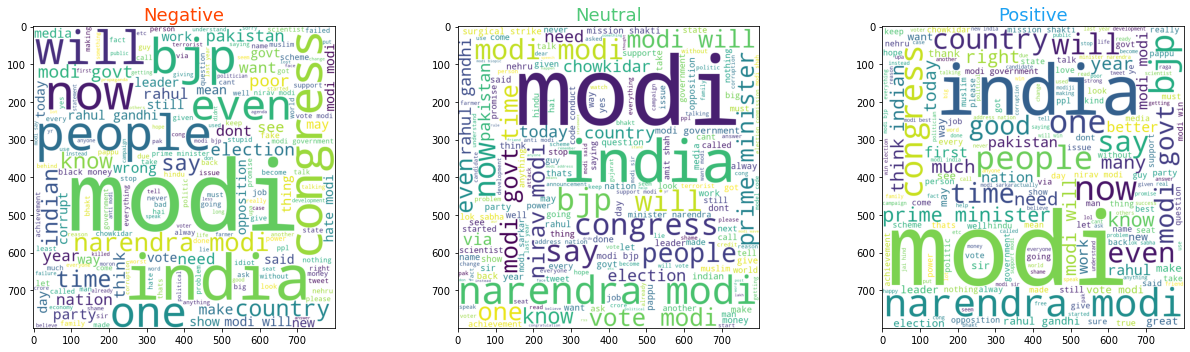

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), facecolor=None)

ax1.imshow(negative_cloud)
ax1.set_title('Negative', fontsize=18, color='#ff4500')

ax2.imshow(neutral_cloud)
ax2.set_title('Neutral', fontsize=18, color='#50C878')

ax3.imshow(positive_cloud)
ax3.set_title('Positive', fontsize=18, color='#1DA1F2')

plt.tight_layout()


### Split Test & Train Data

In [22]:
class Data:
    def __init__(self, df):
        self.df = df

    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])

        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])

        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df


***Split Train and Test Data***

In [23]:
train_X, test_X, train_y, test_y = train_test_split([i for i in twitter_data.comment], [i for i in twitter_data.category], test_size=0.25, random_state=1)


***Vectorize the Comment***

In [24]:
vectorizer = TfidfVectorizer()
train_X_vectors = vectorizer.fit_transform(train_X)
test_X_vectors = vectorizer.transform(test_X)


### Creating Models

***Linear SVC***

In [25]:
clf_svm = LinearSVC()
clf_svm.fit(train_X_vectors, train_y)
clf_prediction = clf_svm.predict(test_X_vectors)

print(f'Accuracy: {clf_svm.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, clf_prediction, average=None, labels=[-1, 0, 1])}')


Accuracy: 0.9441071428571428
Accuracy: [0.89847807 0.96529729 0.94995327]


***MultinomialNB***

In [ ]:
svm_mnb = MultinomialNB()
svm_mnb.fit(train_X_vectors, train_y)
mnb_prediction = svm_mnb.predict(test_X_vectors)

print(f'Accuracy: {svm_mnb.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, mnb_prediction, average=None, labels=[-1, 0, 1])}')


***Decision Tree Classifier***

In [ ]:
svm_dtc = DecisionTreeClassifier()
svm_dtc.fit(train_X_vectors, train_y)
dtc_prediction = svm_dtc.predict(test_X_vectors)

print(f'Accuracy: {svm_dtc.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, dtc_prediction, average=None, labels=[-1, 0, 1])}')


***K-Nearest Neighbour Classifier***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=13,metric="cosine",n_jobs=-1)
knn.fit(train_X_vectors, train_y)
knn_prediction = knn.predict(test_X_vectors)

print(f'Accuracy: {knn.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, knn_prediction, average=None, labels=[-1, 0, 1])}')


Accuracy: 0.5282397959183673
Accuracy: [0.34269068 0.58426024 0.52184731]
